In [1]:
import json
import math
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import namedtuple, OrderedDict
from pathlib import Path

In [2]:
sys.path.insert(0, '../src/lib')

In [24]:
from utils import car_models
from utils.geometry import create_camera_matrix, euler_angles_to_rotation_matrix, euler_angles_to_quaternions, proj_point, proj_points, calc_bbox
from utils.image import affine_transform, get_affine_transform, pad_img_sides, hflip
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.kaggle_cars_utils import parse_annot_str

In [4]:
INPUT_PATH = '../data/pku-autonomous-driving'
MODEL_DIR = os.path.join(INPUT_PATH, 'car_models_json')

In [5]:
def read_split_file(split, data_dir=INPUT_PATH):
    path = os.path.join(data_dir, 'split', split+'.txt')
    with open(path) as f:
        return [line.rstrip('\n')[:-4] for line in f]
    
    
def load_car_models(model_dir=MODEL_DIR):
    """Load all the car models
    """
    car_models_all = OrderedDict([])
    print('loading %d car models' % len(car_models.models))
    for model in car_models.models:
        car_model = '%s/%s.json' % (model_dir, model.name)
        with open(car_model) as json_file:
            car = json.load(json_file)
        for key in ['vertices', 'faces']:
            car[key] = np.array(car[key])
        # fix the inconsistency between obj and pkl
        car['vertices'][:, [0, 1]] *= -1
        car_models_all[model.name] = car 
    return car_models_all  


def imshow(img, boxes=None, figsize=(16,8)):
    plt.figure(figsize=figsize)
    ax = plt.axes()
    if boxes is not None:
        for bbox in boxes:
            rect = plt.Rectangle(
                (bbox[0], bbox[1]),
                bbox[2] - bbox[0],
                bbox[3] - bbox[1], fill=False,
                edgecolor='g', linewidth=1)
            plt.gca().add_patch(rect)
    ax.imshow(img)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_formatter(plt.NullFormatter())


def add_blend_img(back, fore, trans=0.7, white_theme=False):
    if white_theme:
        fore = 255 - fore
    if fore.shape[0] != back.shape[0] or fore.shape[0] != back.shape[1]:
        fore = cv2.resize(fore, (back.shape[1], back.shape[0]))
    if len(fore.shape) == 2:
        fore = fore.reshape(fore.shape[0], fore.shape[1], 1)
    out = (back * (1. - trans) + fore * trans)
    out[out > 255] = 255
    out[out < 0] = 0
    return out.astype(np.uint8).copy()

In [6]:
def load_annotations(df, img_ids):
    anns = []
    models_3D = load_car_models()
    calib = create_camera_matrix()
    anns = [gen_img_annotation(img_id, df, models_3D, calib) 
            for img_id in img_ids]
    return anns


def gen_img_annotation(img_id, df, models_3D, calib):
    cond = df['ImageId'] == img_id
    cars = df.loc[cond, 'PredictionString'].values[0]
    cars = parse_annot_str(str(cars))
    for car in cars:
        car_name = car_models.car_id2name[car['car_id']].name
        car_model = models_3D[car_name]
        pts_2d = proj_points(
            car_model['vertices'], car['rotation'], car['location'], 
            calib)
        car['bbox'] = calc_bbox(pts_2d)
    return cars

In [7]:
# 2x3 x 3x1000 -> 2x1000
def affine_transform_pts(pts, t):
    new_pt = np.vstack([pts.T, np.ones(pts.shape[0])])
    new_pt = t @ new_pt
    return new_pt.T

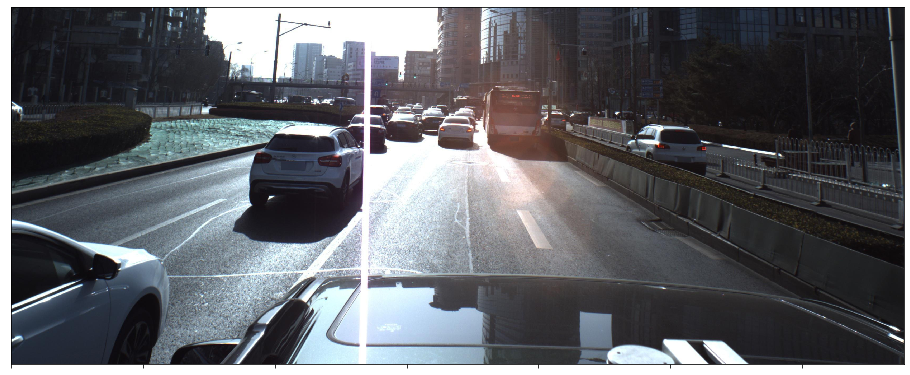

In [8]:
img_id = 'ID_0289b0bc8'
img_path = os.path.join(INPUT_PATH, 'train_images', img_id+'.jpg')
img = cv2.imread(img_path)[:,:,::-1]
y_mid = img.shape[0]//2
img = img[y_mid:]
imshow(img)

In [9]:
img_bottom_half = True
height, width = img.shape[0], img.shape[1]

inp_w, inp_h = 1280, 512
down_ratio = 4
pad_w_pct = 0.3

out_w, out_h = inp_w // down_ratio, inp_h // down_ratio
out_w, out_h

c = np.array([width / 2., height / 2.])
s = np.array([width, height], dtype=np.int32)

num_classes = 1
max_objs = 50
calib = create_camera_matrix()

(width, height), (inp_w, inp_h), (out_w, out_h)

((3384, 1355), (1280, 512), (320, 128))

In [10]:
df = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'))
img_ids = read_split_file('train') + read_split_file('val')
len(img_ids)

4262

In [11]:
%%time
train_anns = load_annotations(df, img_ids)
models_3D = load_car_models()

loading 79 car models
loading 79 car models
CPU times: user 34.2 s, sys: 0 ns, total: 34.2 s
Wall time: 34.3 s


In [12]:
locs = []
for img in train_anns:
    for car in img:
        locs.append(car['location'])
locs = np.vstack(locs)

MEAN, STD, MAX = [], [], []
for d, ax in zip([0, 1, 2], ['x', 'y', 'z']):
    locs_ax = locs[:,d]
    print('[%s] min: %.02f, max: %.02f' % (ax, locs_ax.min(), locs_ax.max()))
    MEAN.append(locs_ax.mean())
    STD.append(locs_ax.std())
    MAX.append(locs_ax.max())

[x] min: -90.42, max: 519.83
[y] min: 1.02, max: 689.12
[z] min: 3.07, max: 3502.94


In [13]:
MEAN, STD, MAX

([-3.562625894086627, 9.644064074551164, 52.10293366395621],
 [14.559878414341837, 6.825925995705231, 40.04567548141306],
 [519.834, 689.119, 3502.94])

In [14]:
def affine_to_world_pts(vertices, rot_euler, translation):
    Rt = np.eye(4)
    Rt[:3, 3] = translation
    Rt[:3,:3] = euler_angles_to_rotation_matrix(rot_euler).T

    # increase dim length from 3 -> 4
    P = np.ones((vertices.shape[0], vertices.shape[1]+1))
    P[:, :-1] = vertices

    pts_world = Rt[:3,:] @ P.T # 3 x vertices
    return pts_world


def proj_world_pts(pts_world, calib):
    pts_3d = (calib[:,:3] @ pts_world).T
    pts_2d = pts_3d[:,:2] / pts_3d[:,2:]
    return pts_2d

In [15]:
count = 0

In [16]:
# stop_counter = False

# if not stop_counter:
#     img_id = img_ids[count]
#     img_anns = train_anns[count]
#     img_anns.sort(key=lambda x: x['location'][2], reverse=True)
#     count += 1

# xy_off = np.array([0, 0])
# img_path = os.path.join(INPUT_PATH, 'train_images', img_id+'.jpg')
# img = cv2.imread(img_path)
# img = img[:,:,::-1]
# if img_bottom_half:
#     y_mid = img.shape[0] // 2
#     img = img[y_mid:]
#     xy_off[1] -= y_mid

# mask = np.zeros((3, height, width), dtype=np.float32)
# num_objs = min(len(img_anns), max_objs)
# bboxes = []

# for k in range(num_objs):
#     ann = img_anns[k]
#     ct = proj_point(ann['location'], calib)
#     car_name = car_models.car_id2name[ann['car_id']].name
#     model_3D = models_3D[car_name]
    
#     pts_world = affine_to_world_pts(
#         model_3D['vertices'], ann['rotation'], ann['location'])
#     pts_2d = proj_world_pts(pts_world, calib)
#     pts_world= pts_world.T
    
#     bbox = calc_bbox(pts_2d)
       
#     ct += xy_off
#     bbox += np.hstack([xy_off, xy_off])
#     pts_2d += xy_off

#     h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    
#     if h > 0 and w > 0:
#         bboxes.append(bbox)
               
#         for face in model_3D['faces'] - 1:
#             pts_face_2d = np.int32(pts_2d[face]).reshape((-1, 1, 2))
#             pts_face_3d = np.int32(pts_world[face])
#             for dim in range(3):
#                 v = pts_face_3d[:,dim].mean() / MAX[dim]
#                 cv2.drawContours(mask[dim], [pts_face_2d], 0, v, -1)

# print(img_id)
# figsize = (20, 10)
    
# for i in range(3):
#     imshow(mask[i], boxes=bboxes, figsize=figsize)

# mask0 = mask[2] / mask[2].max() * 255
# blend = add_blend_img(img, mask0, white_theme=True)
# imshow(blend, boxes=bboxes, figsize=figsize)
# imshow(img, boxes=bboxes, figsize=figsize)

# mask.min(), mask.max()

In [17]:
# path = os.path.join(INPUT_PATH, 'train_3d_masks', img_id)
# np.savez_compressed(path, [mask])

In [18]:
# mask1 = load_3d_loc_mask(img_id)

# for i in range(3):
#     imshow(mask1[0, i], boxes=bboxes, figsize=figsize)

In [19]:
MASKS_PATH = Path(INPUT_PATH)/'train_3d_masks'

def load_3d_loc_mask(img_id, path=MASKS_PATH):
    with np.load(path/(img_id+'.npz')) as f:
        return f['arr_0'][0]

In [20]:
count = 0

ID_008e7e082


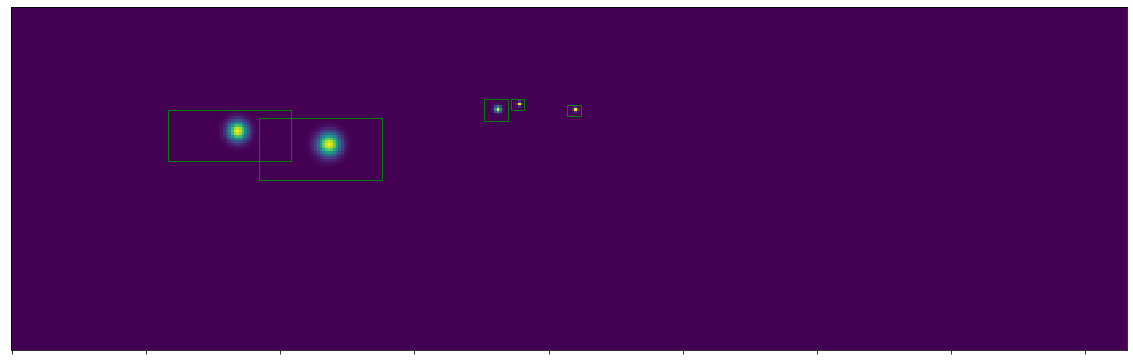

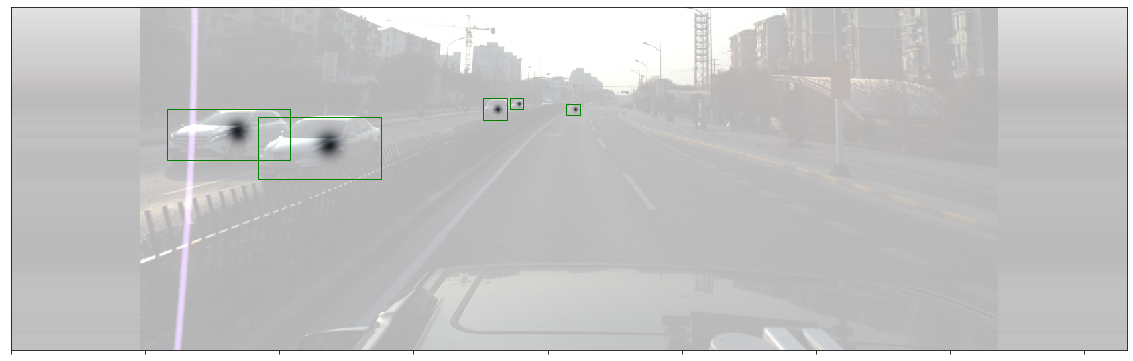

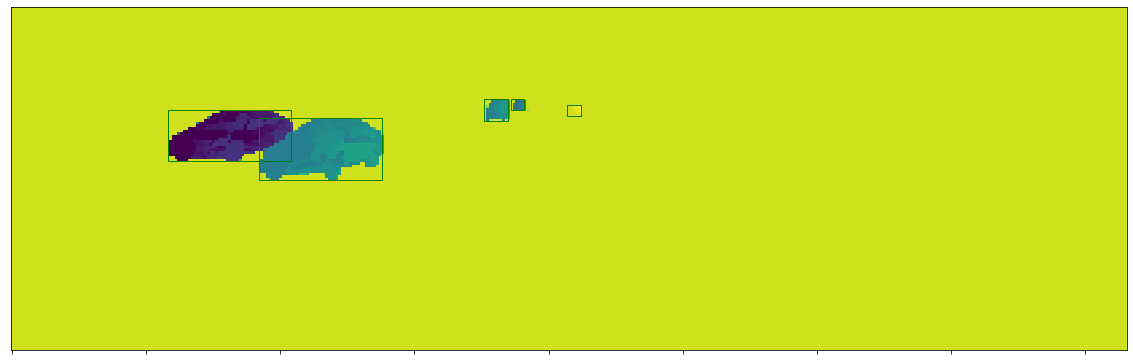

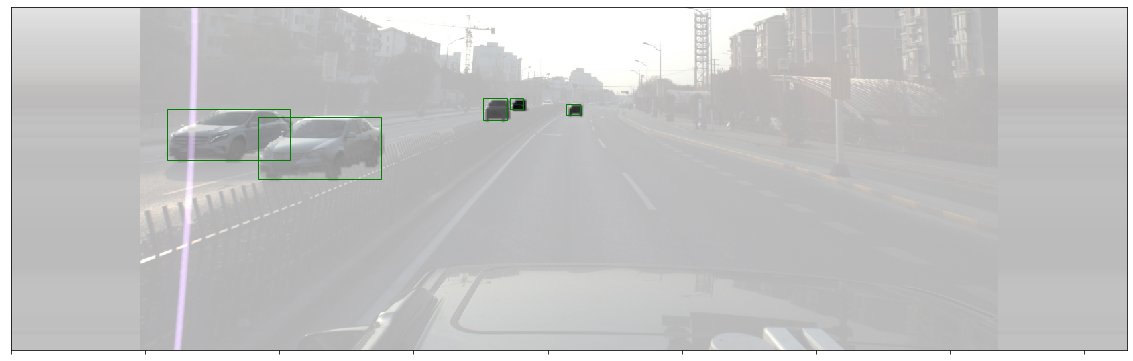

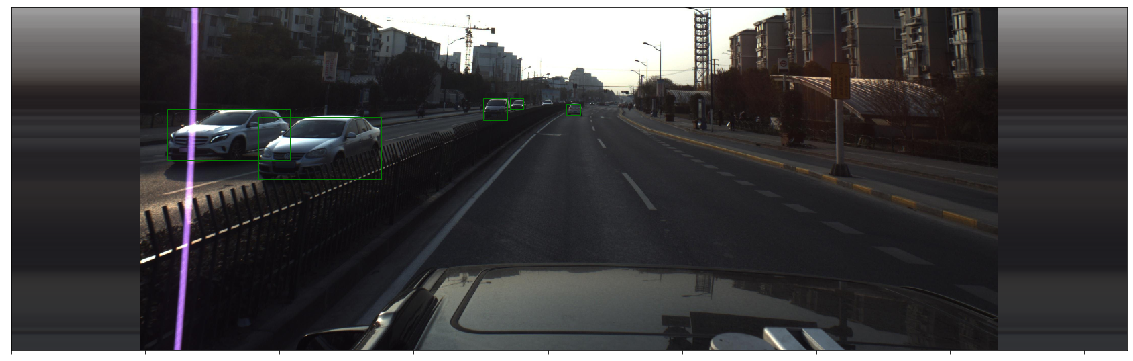

In [100]:
stop_counter = False
flipped = False

if not stop_counter:
    img_id = img_ids[count]
    img_anns = train_anns[count]
    img_anns.sort(key=lambda x: x['location'][2], reverse=True)
    count += 1

xy_off = np.array([0, 0])
img_path = os.path.join(INPUT_PATH, 'train_images', img_id+'.jpg')
img = cv2.imread(img_path)
img = img[:,:,::-1]
if img_bottom_half:
    y_mid = img.shape[0] // 2
    img = img[y_mid:]
    xy_off[1] -= y_mid
xyz_mask = load_3d_loc_mask(img_id)
if flipped:
    xyz_mask[0] = np.where((xyz_mask != 0).any(0), xyz_mask[0].max() - xyz_mask[0], 0)
xyz_mask = xyz_mask.transpose(1, 2, 0) # H,W,C

c = np.array([width / 2., height / 2.])
s = np.array([width, height], dtype=np.int32)
if flipped:
    img = hflip(img, calib[0,2])
    xyz_mask = hflip(xyz_mask, calib[0,2])
    c[0] = width-1 - c[0]
    
trans_input = get_affine_transform(c, s, 0, [inp_w, inp_h])
trans_output = get_affine_transform(c, s, 0, [out_w, out_h])

inp = cv2.warpAffine(
    img, trans_input, (inp_w, inp_h), flags=cv2.INTER_LINEAR)
inp = inp.transpose(2, 0, 1).astype(np.float32)

xyz_mask = cv2.warpAffine(
    xyz_mask, trans_output, (out_w, out_h), flags=cv2.INTER_LINEAR)
xyz_mask = xyz_mask.transpose(2, 0, 1) # C,H,W

hm = np.zeros((num_classes, out_h, out_w), dtype=np.float32)

if pad_w_pct > 0:
    inp = pad_img_sides(inp, pad_w_pct)
    hm = pad_img_sides(hm, pad_w_pct)
    xyz_mask = pad_img_sides(xyz_mask, pad_w_pct, fill_zeros=True)
    xy_off[0] += int(width * pad_w_pct / 2)

num_objs = min(len(img_anns), max_objs)
bboxes = []

for k in range(num_objs):
    ann = img_anns[k]
    ct = proj_point(ann['location'], calib)
    rot_eul = np.copy(ann['rotation'])
    bbox = np.copy(ann['bbox'])
    if flipped:
        ct[0] = width-1 - ct[0]
        bbox[[0, 2]] = width-1 - bbox[[2, 0]]
        rot_eul[[1, 2]] = -rot_eul[[1, 2]]
    ct += xy_off
    bbox += np.hstack([xy_off, xy_off])

    ct = affine_transform(ct, trans_output)
    ct0 = np.copy(ct)
    ct[0] = np.clip(ct[0], 0, hm.shape[2] - 1)
    ct[1] = np.clip(ct[1], 0, hm.shape[1] - 1)
    ct_int = ct.astype(np.int32)
    bbox[:2] = affine_transform(bbox[:2], trans_output)
    bbox[2:] = affine_transform(bbox[2:], trans_output)
    bbox[[0, 2]] = np.clip(bbox[[0, 2]], 0, hm.shape[2] - 1)
    bbox[[1, 3]] = np.clip(bbox[[1, 3]], 0, hm.shape[1] - 1)

    h, w = bbox[3] - bbox[1], bbox[2] - bbox[0]
    if h > 0 and w > 0:
        radius = gaussian_radius((h, w))
        radius = max(0, int(radius))
        draw_umich_gaussian(hm[0], ct, radius)
        bboxes.append(bbox)

print(img_id)
figsize = (20, 10)

imshow(hm[0], boxes=bboxes, figsize=figsize)

inp0 = inp.transpose(1, 2, 0)
bboxes0 = [bb * down_ratio for bb in bboxes]
blend = add_blend_img(inp0, hm[0] * 255, white_theme=True)
imshow(blend, boxes=bboxes0, figsize=figsize)

for i in range(1):
    imshow(xyz_mask[i], boxes=bboxes, figsize=figsize)

mask0 = xyz_mask[2] / xyz_mask[2].max() * 255
blend = add_blend_img(inp0, mask0, white_theme=True)
imshow(blend, boxes=bboxes0, figsize=figsize)

imshow(inp0.astype(np.uint8), boxes=bboxes0, figsize=figsize)

In [110]:
np.random.rand(4,3,2)[:1].shape

(1, 3, 2)